In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Dataset: FoodAPS National Household Food Acquisition and Purchase Survey

This dataset contains the results of the USDA's National Household Food Acquisition and Purchase Survey (FoodAPS). It
collects information about "foods purchased or otherwise acquired for consumption at home and away from home, including
foods acquired through food and nutrition assistance programs."


In [26]:
hh_df = pd.read_csv("data/faps_household_puf.csv")

fah_df = pd.read_csv("data/faps_fahnutrients.csv")
fafh_df = pd.read_csv("data/faps_fafhnutrient_puf.csv")

In [27]:
hh_df = hh_df[(hh_df["numguests"] == 0) & (hh_df["hhsizechange"] == 0)]

In [28]:
import enum


class SNAPNowAdmin(enum.Enum):
    NO_MATCH = 0
    CONFIRMED_SNAP = 1
    CONFIRMED_NON_SNAP = 2
    VALID_SKIP = -996


hh_df = hh_df[hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value]

In [29]:
hh_nums = hh_df["hhnum"]

fah_df = fah_df[fah_df["hhnum"].isin(hh_nums)]
fafh_df = fafh_df[fafh_df["hhnum"].isin(hh_nums)]

In [30]:
REQUIRED_VARIABLES = ["totsug", "satfat"]

fah_df = fah_df[REQUIRED_VARIABLES]
fafh_df = fafh_df[REQUIRED_VARIABLES]

In [31]:
fah_df = fah_df.dropna(how="all")
fafh_df = fafh_df.dropna(how="all")

In [32]:
fah_df = fah_df.fillna(0, inplace=True)
fafh_df = fafh_df.fillna(0, inplace=True)

! note for write-up: func is for reusability, avoiding polluting the notebook with variables, and allowing df copies to be garbage collected and free memory


In [33]:
def show_boxplots() -> None:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

    plot_col_names = {"totsug": "Total Sugars (g, per 100g)", "satfat": "Total Saturated Fatty Acids (g, per 100g)"}

    fah_df.rename(columns=plot_col_names).boxplot(ax=ax1)
    ax1.set_title("Food at Home (per Item)")

    fafh_df.rename(columns=plot_col_names).boxplot(ax=ax2)
    ax2.set_title("Food Away From Home (per Item)")

    plt.tight_layout()
    plt.show()

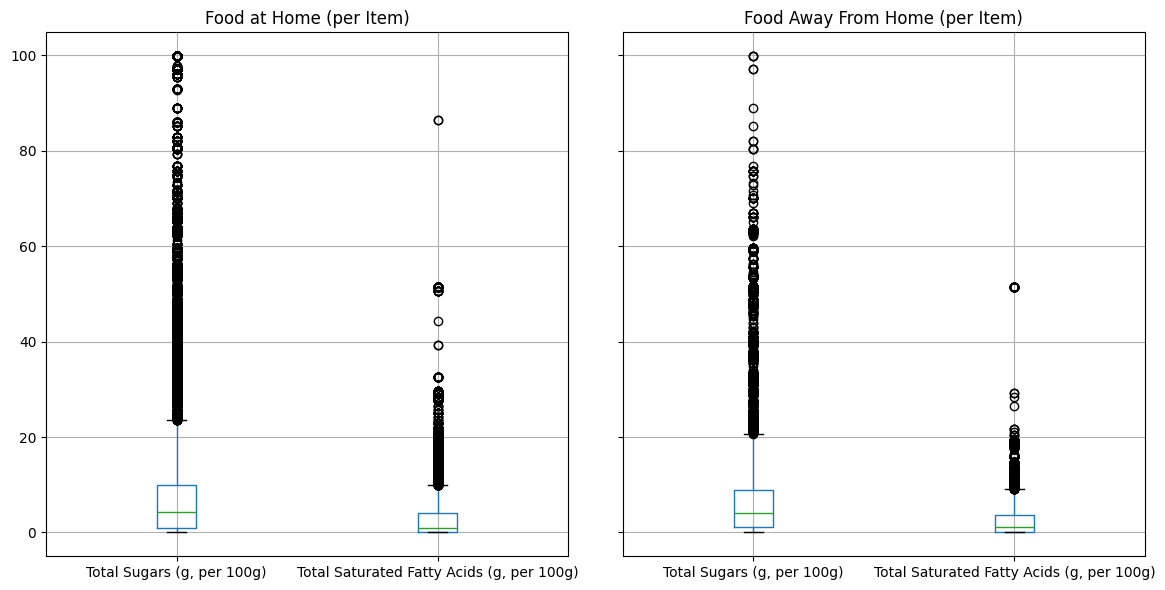

In [34]:
show_boxplots()

In [35]:
fah_df = fah_df.apply(np.log)
fafh_df = fafh_df.apply(np.log)

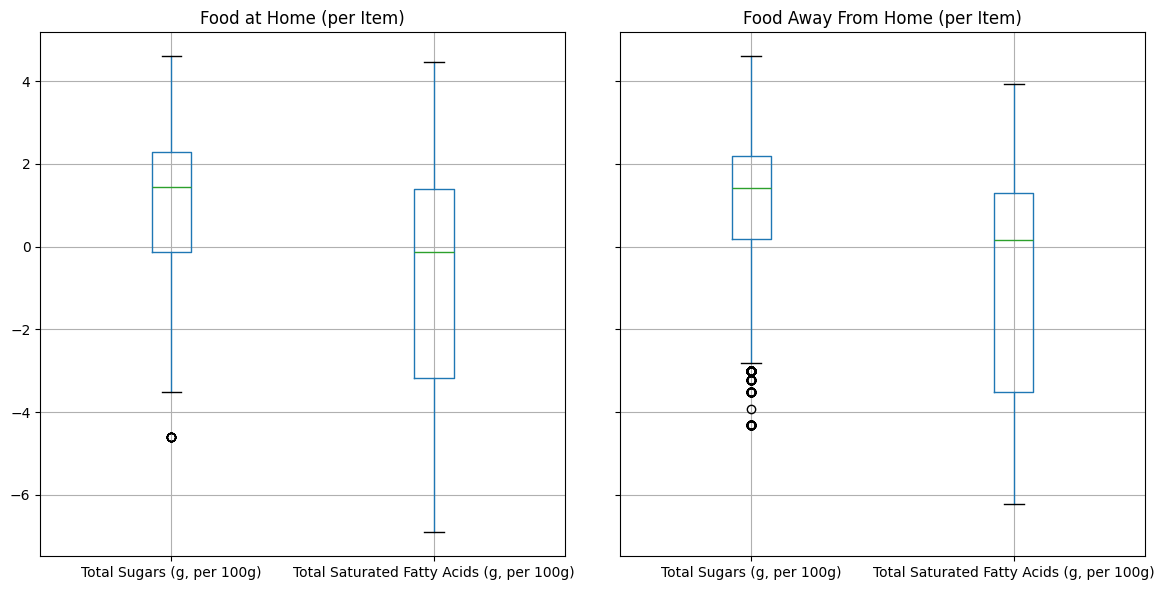

In [36]:
show_boxplots()